In [1]:

import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /Users/kevinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-07-21 14:19:57.569557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
df=pd.read_csv('spam.csv', encoding='latin')

In [57]:
df['text']=df.v2
df['spam']=df.v1
df=df.drop(['v1','v2','Unnamed: 2','Unnamed: 3', 'Unnamed: 4'],axis=1)

In [58]:
df.head()

,text,spam
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [59]:
def spam_or_ham(x):
    if(x=='ham'):
        return 0
    return 1
df['spam'] = df['spam'].map(lambda x:spam_or_ham(x))

In [60]:
df.head()

,text,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [61]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) # converting shortened words to original (Eg:"I'm" to "I am")
      sms = sms.lower() # lower casing the sms
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() #splitting
      # lemmatization and stopword removal
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X = df["text"].apply(preprocessing)

In [62]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["spam"])

In [63]:
X.head()


0    go jurong point crazy available bugis n great ...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final tkts st ...
3                      dun say early hor c already say
4                  nah think go usf life around though
Name: text, dtype: object

In [64]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [65]:
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X)

In [66]:
for i in range(5):
           print("Text               : ",X[i] )
           print("Numerical Sequence : ", text_to_sequence[i])

Text               :  go jurong point crazy available bugis n great world la e buffet cine got amore wat
Numerical Sequence :  [3, 3575, 255, 549, 522, 1028, 35, 56, 236, 845, 80, 2411, 1029, 9, 3576, 70]
Text               :  ok lar joking wif oni
Numerical Sequence :  [6, 220, 1173, 328, 1539]
Text               :  free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply over
Numerical Sequence :  [5, 342, 582, 724, 92, 1540, 846, 478, 1541, 147, 175, 17, 1540, 221, 342, 2412, 23, 2413, 263, 2414]
Text               :  dun say early hor c already say
Numerical Sequence :  [142, 48, 256, 2415, 69, 75, 48]
Text               :  nah think go usf life around though
Numerical Sequence :  [774, 33, 3, 725, 86, 121, 195]


In [67]:
max_length_sequence = max([len(i) for i in text_to_sequence])
 # finding the length of largest sequence
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence

array([[   0,    0,    0, ...,    9, 3576,   70],
       [   0,    0,    0, ..., 1173,  328, 1539],
       [   0,    0,    0, ..., 2413,  263, 2414],
       ...,
       [   0,    0,    0, ..., 1024, 7818, 3573],
       [   0,    0,    0, ...,  789,   67,    5],
       [   0,    0,    0, ..., 2147,  363,  145]], dtype=int32)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sms_sequence, y, test_size=0.33, random_state=42)

In [69]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
    
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 79, 32)            250240    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                2020      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 305481 (1.17 MB)
Trainable params: 30548

In [70]:
lstm_model.fit(X_train, y_train, epochs = 5, validation_split=0.2, batch_size=16)

Epoch 1/5
187/187 [==============================] - 6s 25ms/step - loss: 0.2322 - accuracy: 0.9270 - val_loss: 0.0886 - val_accuracy: 0.9719
Epoch 2/5
187/187 [==============================] - 4s 19ms/step - loss: 0.0399 - accuracy: 0.9896 - val_loss: 0.0730 - val_accuracy: 0.9799
Epoch 3/5
187/187 [==============================] - 4s 21ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.1012 - val_accuracy: 0.9732
Epoch 4/5
187/187 [==============================] - 4s 23ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.1223 - val_accuracy: 0.9705
Epoch 5/5
187/187 [==============================] - 4s 21ms/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 0.1706 - val_accuracy: 0.9772


In [89]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = lstm_model.predict(X_test,batch_size =16)

from sklearn.preprocessing import MultiLabelBinarizer
y_pred= MultiLabelBinarizer().fit_transform(y_pred)
np.unique(y_pred)

#df_test = pd.DataFrame({'true': y_test, 'pred':y_pred.tolist()})
#df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
#print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
#print(classification_report(df_test.true, df_test.pred))


115/115 [==============================] - 1s 7ms/step


array([0, 1])

In [17]:
df2=pd.read_csv('DataSet.csv', encoding='latin')

In [18]:
df2.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI â Environmental Syst...,<ul>\r\n<li>\r\n<b>EDUCATION:Â </b>Bachelorâ...,<p>Our culture is anything but corporateâwe ...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


<Axes: xlabel='fraudulent', ylabel='count'>

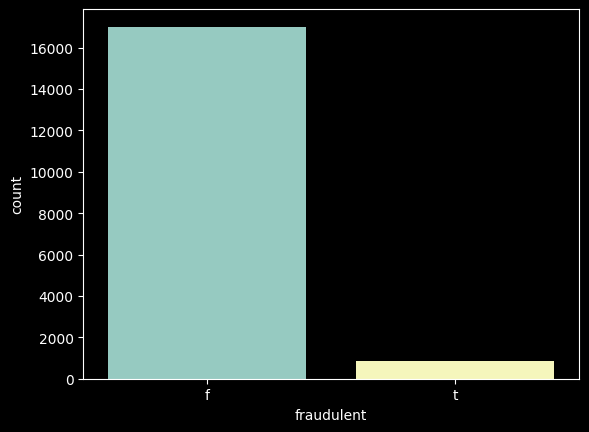

In [19]:
sns.countplot(x=df2["fraudulent"])

In [20]:
df2.dtypes

title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting          object
has_company_logo       object
has_questions          object
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent             object
in_balanced_dataset    object
dtype: object

In [21]:
df2.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64

In [22]:
df2.shape

(17880, 18)

In [23]:
def offersSalary(x):
    if(x!=None):
        return 0
    return 1
df2['hasSalary'] = df2['salary_range'].map(lambda x:offersSalary(x))
df2.drop(['salary_range'],axis=1)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,hasSalary
0,Marketing Intern,"US, NY, New York",Marketing,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI â Environmental Syst...,<ul>\r\n<li>\r\n<b>EDUCATION:Â </b>Bachelorâ...,<p>Our culture is anything but corporateâwe ...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,<p>Vend is looking for some awesome new talent...,<p>Just in case this is the first time youâv...,<p>To ace this role you:</p>\r\n<ul>\r\n<li>Wi...,<p><b>What can you expect from us?</b></p>\r\n...,f,t,t,Full-time,Mid-Senior level,NaN,Computer Software,Sales,f,f,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,<p>WebLinc is the e-commerce platform and serv...,<p></p>\r\n<p>The Payroll Accountant will focu...,<p></p>\r\n<p>- B.A. or B.S. in Accounting</p>...,<p></p>\r\n<h3>Health &amp; Wellness</h3>\r\n<...,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,f,f,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,<p>We Provide Full Time Permanent Positions fo...,<p>Experienced Project Cost Control Staff Engi...,<ul>\r\n<li>At least 12 years professional exp...,NaN,f,f,f,Full-time,NaN,NaN,NaN,NaN,f,f,0
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,<p>Nemsia Studios is looking for an experience...,<p>1. Must be fluent in the latest versions of...,<p>Competitive salary (compensation will be ba...,f,f,t,Contract,Not Applicable,Professional,Graphic Design,Design,f,f,0


In [24]:
df2_fraudulent=df2[df2['fraudulent']=='t']
df2_fraudulent

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,hasSalary
98,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,<p>Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â...,"<p><b><img src=""#URL_ae07dc35dfe86ebc1101b48ee...",<h3><b>Qualifications</b></h3>\r\n<p><b>Knowle...,<p><b>BENEFITS</b></p>\r\n<p><b>What is offere...,f,t,t,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,t,f,0
144,Forward Cap.,NaN,NaN,NaN,NaN,<p>The group has raised a fund for the purchas...,NaN,NaN,f,f,f,NaN,NaN,NaN,NaN,NaN,t,t,0
173,Technician Instrument & Controls,US,Power Plant & Energy,NaN,"<p><img src=""#URL_044fce3aa43cecf7fd7f1fd790ab...",<p><b>Technician Instrument &amp; Controls</b>...,<p><b>JOB QUALIFICATIONS</b><br><br>-Ability t...,"<p>we are a team of almost 8,000 employees who...",f,t,t,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,t,f,0
180,Sales Executive,"PK, SD, Karachi",Sales,NaN,NaN,<p>Sales Executive</p>,<p>Sales Executive</p>,<p>Sales Executive</p>,f,f,f,NaN,NaN,NaN,NaN,Sales,t,t,0
215,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,<p>Â Â Â Â Â Â Â Â Â Â Â Â Â Â Â...,"<p><b><img src=""#URL_ae07dc35dfe86ebc1101b48ee...",<h3><b>Â Qualifications</b></h3>\r\n<p><b>Know...,<p><b>BENEFITS</b></p>\r\n<p><b>What is offere...,f,t,t,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,t,f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17827,Student Positions Part-Time and Full-Time.,"US, CA, Los Angeles",NaN,NaN,NaN,<p>Student Positions Part-Time and Full-Time.<...,NaN,NaN,f,f,f,Part-time,NaN,NaN,NaN,NaN,t,t,0
17828,Sales Associate,"AU, NSW, Sydney",Sales and Marketing,NaN,NaN,<p><b>LEARN TO EARN AN EXECUTIVE LEVEL INCOME<...,<p><b>What You Can Do.</b></p>\r\n<p><b>Â </b>...,<p><b>Who We Are</b></p>\r\n<p><b>Â </b></p>\r...,f,f,t,NaN,NaN,NaN,NaN,NaN,t,t,0
17829,Android Developer,"PL, MZ, Warsaw",NaN,NaN,NaN,<p>inFullMobile Sp. z o.o. is a mobile softwar...,<p>â¢ A proven track record in Android / JAVA...,<ul>\r\n<li>attractive salary (adequate to the...,f,f,f,NaN,NaN,NaN,NaN,NaN,t,t,0
17830,Payroll Clerk,"US, NY, New York",NaN,NaN,NaN,<p>JOB DESCRIPTION<br><br>We are seeking a ful...,<p><br>JOB REQUIREMENTS<br><br>â¢Â Â Â High ...,<p>We offer a competitive salary and benefits ...,f,f,f,Full-time,NaN,NaN,Apparel & Fashion,Accounting/Auditing,t,t,0


In [25]:
df2_fraudulent.count()

title                  866
location               847
department             335
salary_range           223
company_profile        279
description            866
requirements           713
benefits               503
telecommuting          866
has_company_logo       866
has_questions          866
employment_type        625
required_experience    431
required_education     415
industry               591
function               529
fraudulent             866
in_balanced_dataset    866
hasSalary              866
dtype: int64

In [26]:
def fraudulent(x):
    if(x=='f'):
        return 0
    return 1
df_OD = df2[['fraudulent', 'description']].copy()
df_OD.head()
df_OD['scam'] = df2['fraudulent'].map(lambda x:fraudulent(x))
df_OD['text']= df2['description'].copy()
df_OD.head()

,fraudulent,description,scam,text
0,f,"<p>Food52, a fast-growing, James Beard Award-w...",0,"<p>Food52, a fast-growing, James Beard Award-w..."
1,f,<p>Organised - Focused - Vibrant - Awesome!<br...,0,<p>Organised - Focused - Vibrant - Awesome!<br...
2,f,"<p>Our client, located in Houston, is actively...",0,"<p>Our client, located in Houston, is actively..."
3,f,<p><b>THE COMPANY: ESRI â Environmental Syst...,0,<p><b>THE COMPANY: ESRI â Environmental Syst...
4,f,<p><b>JOB TITLE:</b> Itemization Review Manage...,0,<p><b>JOB TITLE:</b> Itemization Review Manage...


In [27]:
df_OD=df_OD.drop(['fraudulent', 'description'], axis=1)
df_OD= df_OD.iloc[:1000]
df_OD.head()


,scam,text
0,0,"<p>Food52, a fast-growing, James Beard Award-w..."
1,0,<p>Organised - Focused - Vibrant - Awesome!<br...
2,0,"<p>Our client, located in Houston, is actively..."
3,0,<p><b>THE COMPANY: ESRI â Environmental Syst...
4,0,<p><b>JOB TITLE:</b> Itemization Review Manage...


In [28]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) # converting shortened words to original (Eg:"I'm" to "I am")
      sms = sms.lower() # lower casing the sms
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() #splitting
      # lemmatization and stopword removal
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X = df_OD["text"].apply(preprocessing)

In [29]:
df_OD.head()

,scam,text
0,0,"<p>Food52, a fast-growing, James Beard Award-w..."
1,0,<p>Organised - Focused - Vibrant - Awesome!<br...
2,0,"<p>Our client, located in Houston, is actively..."
3,0,<p><b>THE COMPANY: ESRI â Environmental Syst...
4,0,<p><b>JOB TITLE:</b> Itemization Review Manage...


In [30]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df_OD["scam"])

In [31]:
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X)

In [32]:
for i in range(5):
           print("Text               : ",X[i] )
           print("Numerical Sequence : ", text_to_sequence[i])

Text               :  pfood fastgrowing james beard awardwinning online food community crowdsourced curated recipe hub currently interviewing full parttime unpaid intern work small team editor executive developer new york city headquarterspullireproducing andor repackaging existing food content number partner site huffington post yahoo buzzfeed various content management systemsliliresearching blog website provision food affiliate programliliassisting daytoday affiliate program support screening affiliate assisting affiliate inquirieslilisupporting pr amp event neededlilihelping office administrative work filing mailing preparing meetingsliliworking developer document bug suggest improvement sitelilisupporting marketing executive staffliul
Numerical Sequence :  [3395, 1083, 6141, 6142, 1994, 183, 384, 300, 6143, 4301, 2521, 2868, 226, 2522, 231, 1385, 3396, 824, 8, 159, 4, 2523, 338, 106, 13, 500, 461, 6144, 215, 6145, 141, 384, 177, 353, 214, 70, 6146, 888, 1819, 6147, 152, 177, 22, 6

In [33]:
max_length_sequence = max([len(i) for i in text_to_sequence])
 # finding the length of largest sequence
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence

array([[    0,     0,     0, ...,    28,   338,  6154],
       [    0,     0,     0, ...,   644,  6180,  6181],
       [    0,     0,     0, ...,   339,   122,  6182],
       ...,
       [    0,     0,     0, ...,   412,  2308, 17096],
       [    0,     0,     0, ...,   361,   579,  5605],
       [    0,     0,     0, ...,    78,   116,  2052]], dtype=int32)

In [34]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
    
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2627, 32)          547456    
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                2020      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 602697 (2.30 MB)
Trainable params: 60269

In [35]:
lstm_model.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.2, batch_size=16)

Epoch 1/5
50/50 [==============================] - 38s 726ms/step - loss: 0.2471 - accuracy: 0.9712 - val_loss: 0.2016 - val_accuracy: 0.9550
Epoch 2/5
50/50 [==============================] - 36s 712ms/step - loss: 0.1084 - accuracy: 0.9812 - val_loss: 0.2169 - val_accuracy: 0.9550
Epoch 3/5
50/50 [==============================] - 36s 724ms/step - loss: 0.1142 - accuracy: 0.9812 - val_loss: 0.1857 - val_accuracy: 0.9550
Epoch 4/5
50/50 [==============================] - 39s 782ms/step - loss: 0.1098 - accuracy: 0.9812 - val_loss: 0.2063 - val_accuracy: 0.9550
Epoch 5/5
50/50 [==============================] - 35s 709ms/step - loss: 0.0836 - accuracy: 0.9825 - val_loss: 0.1645 - val_accuracy: 0.9550
